In [1]:
import pickle
import numpy as np

# Setup

In [2]:
data = pickle.load(open("data/emotype_v10_val.p", "rb" )) 

In [3]:
data[0].keys()

dict_keys(['prediction', 'encoding', 'outputs', 'text', 'label'])

In [4]:
data[0]['label']

'happy'

In [5]:
data[0]['outputs']

array([[ -0.73424715,  -2.38374352, -13.02863979,  -6.47953272,
         -4.31223583, -13.12273502,  -3.39076114,   5.66598797]], dtype=float32)

In [6]:
label_cluster_dict = {'addiction':0, 'anxiety':1, 'autism':2, 
                     'bipolar':3, 'conversation':4, 'depression':5, 
                     'happy':6, 'schizophrenia':7}

In [7]:
def get_np_array_version_of_data_dict_elements(data):
    
    embeddings = np.zeros((len(data), data[0]['encoding'].shape[1]))
    outputs = np.zeros((len(data), data[0]['outputs'].shape[1]))
    true_labels = [None] * len(data)
    pred_labels = [None] * len(data)
    text = [None] * len(data)
    
    for k in data.keys():
        embeddings[k, :] = data[k]['encoding']
        outputs[k, :] = data[k]['outputs']
        true_labels[k] = data[k]['label']
        pred_labels[k] = data[k]['prediction']
        text[k] = data[k]['text']
    
    
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    text = np.array(text)
    
    return embeddings, outputs, true_labels, pred_labels, text, 

In [8]:
npy_conversion_results = get_np_array_version_of_data_dict_elements(data)
embeddings, outputs, true_labels, pred_labels, text = npy_conversion_results

In [9]:
np.sum(true_labels != 'conversation')  # How many OP's that aren't conversation?

700

In [10]:
psycho_embeddings = embeddings[true_labels != 'conversation']
psycho_labels = true_labels[true_labels != 'conversation']
psycho_embeddings_no_dep = psycho_embeddings[psycho_labels != 'depression']
psycho_labels_no_dep = psycho_labels[psycho_labels != 'depression']

In [11]:
psycho_embeddings.shape

(700, 128)

Checking the distribution of the embeddings...

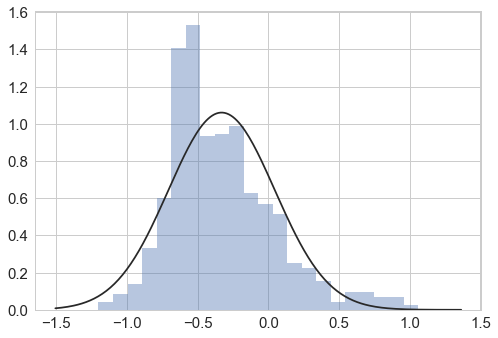

In [27]:
import seaborn as sns
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

sns.set_style("whitegrid")
sns.distplot(psycho_embeddings[:, 0], kde=False, fit=scipy.stats.norm)
plt.show()

# Dimension Reduction

In [14]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def find_optimal_num_pca_components(X_mat, min_num_components, max_num_components, interval):
    """Find optimal # of PCA components via cross-validation
    
    Args:
        X_mat: The data matrix, num obs rows with num vars columns
        min_num_components: The minimum number of components to try
        max_num_components: The maximum number of components to try
    
    Returns:
        n_components_pca: The optimal number of components under cross-validation
    """
    n_components = np.arange(min_num_components, max_num_components, 1)
    
    def compute_scores(X):
        pca = PCA(svd_solver='full')
        pca_scores = []
        for n in n_components:
            # Print a few times (5 in this case) during the process of finding PCA components
            if n % 10 == 0:
                print("Running dimensionality reduction for {} components...".format(n))
            pca.n_components = n
            pca_scores.append(np.mean(cross_val_score(pca, X)))
        return pca_scores
    
    # 'compute_scores' Calculates average log-likelihood over all validation-fold samples
    # using Probabilistic Principal Component Analysis model given by 
    # M. Tipping and C. Bishop, Probabilistic Principal Component Analysis, 
    # Journal of the Royal Statistical Society
    pca_cv_scores = compute_scores(X_mat)
    n_components_pca = n_components[np.argmax(pca_cv_scores)]
    print("best n_components by PCA CV = %d" % n_components_pca)
    return n_components_pca, n_components, pca_cv_scores

In [15]:
psycho_best_n_pca_comps, n_components_seq, pca_cv_scores = find_optimal_num_pca_components(psycho_embeddings, 5, 65, 5)

Running dimensionality reduction for 10 components...
Running dimensionality reduction for 20 components...
Running dimensionality reduction for 30 components...
Running dimensionality reduction for 40 components...
Running dimensionality reduction for 50 components...
Running dimensionality reduction for 60 components...
best n_components by PCA CV = 37


In [38]:
def plot_pca_scores(best_n_components, n_components_seq, pca_scores):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(n_components_seq, pca_scores, 'b', label='PCA scores')
    plt.axvline(best_n_components, color='b',
                label='Optimal No. PCs: %d' % best_n_components, linestyle='--')
    plt.xlabel('Number of Principal Components', fontsize=20)
    plt.ylabel('Log-Likelihood on Validation Fold', fontsize=20)
    legend = plt.legend(loc='lower right')
    legend = plt.legend(frameon = 1)
    for txt in legend.get_texts():
        txt.set_size('large')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    # plt.setp(frame.get_texts(), fontsize='12')
    plt.title('Choosing the Optimal Number of Components in PCA\n' + \
              'via Log-Likelihood with Cross-Validation', fontsize=20)
    plt.show()

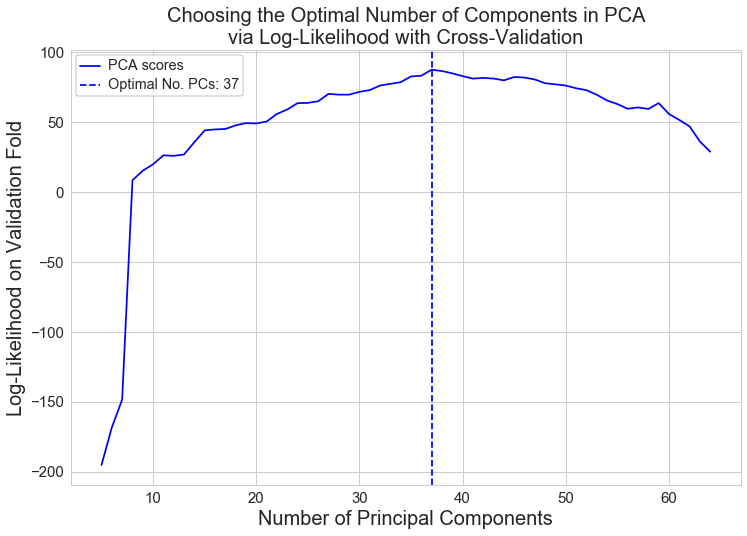

In [39]:
plot_pca_scores(psycho_best_n_pca_comps, n_components_seq, pca_cv_scores)

In [47]:
best_n_pca_comps, _, _ = find_optimal_num_pca_components(embeddings, 5, 60, 5)

Running dimensionality reduction for 10 components...
Running dimensionality reduction for 20 components...
Running dimensionality reduction for 30 components...
Running dimensionality reduction for 40 components...
Running dimensionality reduction for 50 components...
best n_components by PCA CV = 37


In [48]:
embeddings_pca = PCA(n_components=best_n_pca_comps)
embeddings_pca.fit(embeddings)
embeddings_pca_scores = embeddings_pca.transform(embeddings)
psycho_embeddings_pca = PCA(n_components=psycho_best_n_pca_comps)
psycho_embeddings_pca.fit(psycho_embeddings)
psycho_embeddings_pca_scores = psycho_embeddings_pca.transform(psycho_embeddings)
# psycho_embeddings_pca.fit(psycho_embeddings_no_dep)
psycho_embeddings_pca_no_dep_scores = psycho_embeddings_pca.transform(psycho_embeddings_no_dep)

In [49]:
psycho_embeddings_pca_no_dep_scores.shape

(600, 37)

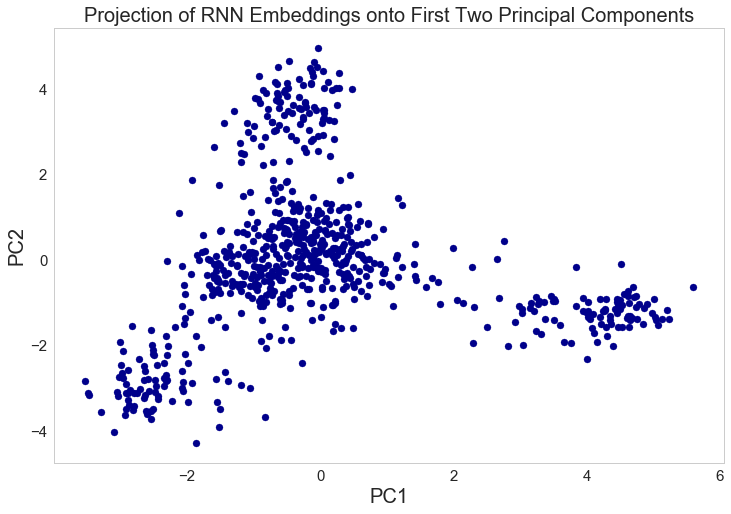

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(psycho_embeddings_pca_scores[:, 0], 
           psycho_embeddings_pca_scores[:, 1], 
           color='darkblue', label='PCA scores')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.grid(False)
plt.title('Projection of RNN Embeddings onto First Two Principal Components', fontsize=20)
plt.show()

In [51]:
color_map = plt.cm.get_cmap(name='tab10', lut=None).colors

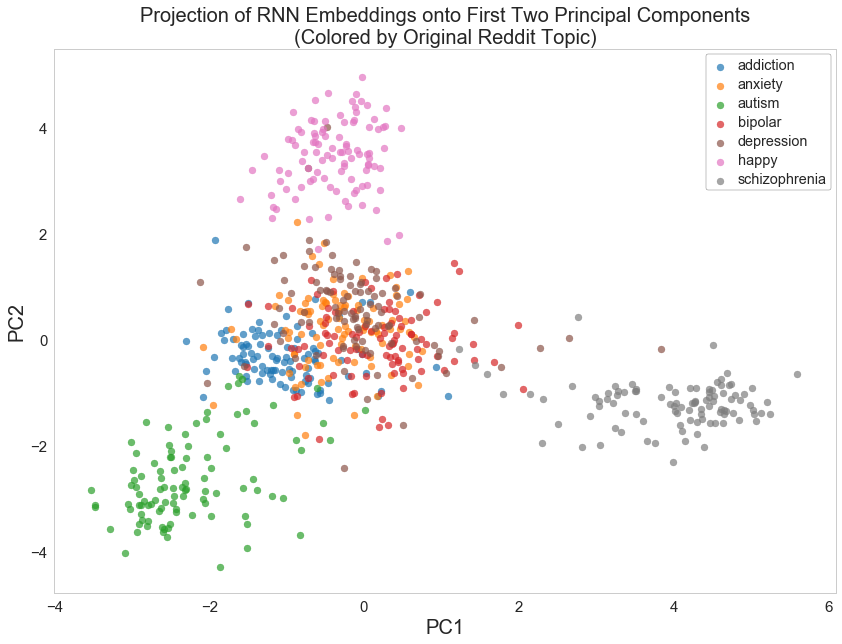

In [68]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14,10))
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)

plt.title('Projection of RNN Embeddings onto First Two Principal Components\n' + \
           '(Colored by Original Reddit Topic)', fontsize=20)
# for y in ['addiction', 'anxiety', 'depression']:
for y in np.unique(true_labels):
    if y == 'conversation':
        continue
    ax.scatter(psycho_embeddings_pca_scores[psycho_labels == y, 0],
               psycho_embeddings_pca_scores[psycho_labels == y, 1], 
               label = y,
               color = color_map[label_cluster_dict[y]],
               alpha=0.7,
               cmap='tab10')
ax.grid(False)
legend = plt.legend(loc='lower right')
legend = plt.legend(frameon = 1)
for txt in legend.get_texts():
    txt.set_size('large')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# plt.setp(frame.get_texts(), fontsize='12')
plt.show()

In [71]:
np.unique(psycho_labels)

array(['addiction', 'anxiety', 'autism', 'bipolar', 'depression', 'happy',
       'schizophrenia'],
      dtype='<U13')

In [70]:
psycho_embeddings_no_dep.shape

(600, 128)

## K-Means Clustering

### Find the silhouette score for a number of different clusterings

In [106]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# n_optimal_clusters_kmeans, n_components_seq, sil_scores

def find_optimal_num_clusters_kmeans(X, min_num_clusters=2, max_num_clusters=12):
    n_components_seq = range(min_num_clusters, max_num_clusters)
    n_optimal_clusters_kmeans = 0
    silhouette_scores = []
    best_cluster_labels = []
    best_sil_score = -np.infty
    for n_clusters in n_components_seq:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, verbose=0)
        tmp_cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, tmp_cluster_labels)
        if silhouette_avg > best_sil_score:
            best_sil_score = silhouette_avg
            best_cluster_labels = tmp_cluster_labels
            n_optimal_clusters_kmeans = n_clusters
        silhouette_scores.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
              "the average silhouette_score is :", silhouette_avg)
    return n_optimal_clusters_kmeans, best_cluster_labels, n_components_seq, silhouette_scores

In [107]:
n_kmeans, cluster_labels, n_comps_seq, sil_scores = find_optimal_num_clusters_kmeans(psycho_embeddings_pca_scores)

For n_clusters = 2 the average silhouette_score is : 0.216415992955
For n_clusters = 3 the average silhouette_score is : 0.258153507164
For n_clusters = 4 the average silhouette_score is : 0.312470451949
For n_clusters = 5 the average silhouette_score is : 0.356955671782
For n_clusters = 6 the average silhouette_score is : 0.37444106307
For n_clusters = 7 the average silhouette_score is : 0.382231506957
For n_clusters = 8 the average silhouette_score is : 0.370449017971
For n_clusters = 9 the average silhouette_score is : 0.341475903971
For n_clusters = 10 the average silhouette_score is : 0.318244792181
For n_clusters = 11 the average silhouette_score is : 0.265746603425


In [108]:
def plot_silhouette_scores(best_n_clusters, n_comps_seq, sil_scores):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(n_comps_seq, sil_scores, 'b', label='Silhouette Scores')
    plt.axvline(best_n_clusters, color='b',
                label='Optimal Num. of Clusters: %d' % best_n_clusters, linestyle='--')
    plt.xlabel('Number of Clusters', fontsize=20)
    plt.ylabel('Average Silhouette Score', fontsize=20)
    legend = plt.legend(loc='best')
    legend = plt.legend(frameon = 1)
    for txt in legend.get_texts():
        txt.set_size('large')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    # plt.setp(frame.get_texts(), fontsize='12')
    plt.title('Choosing the Optimal Number of Clusters for All Emotional Types\n' + \
              'via Average Silhouette Score with K-Means Clustering', fontsize=20)
    plt.show()

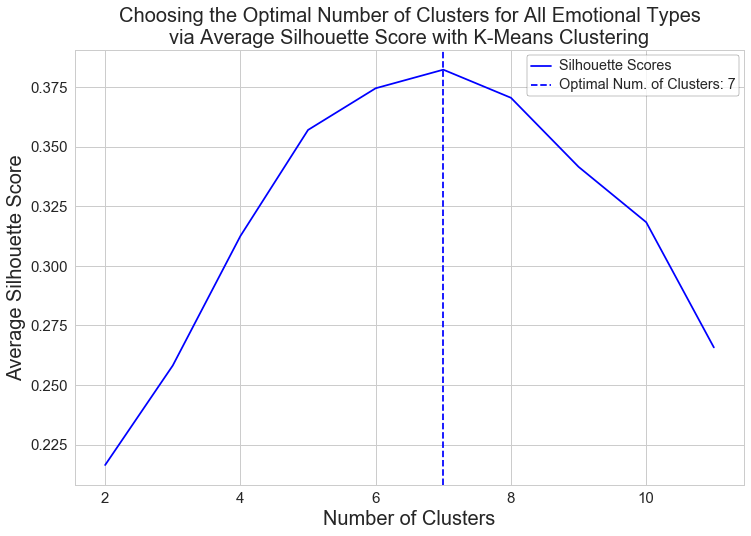

In [109]:
plot_silhouette_scores(n_kmeans, n_comps_seq, sil_scores)

In [104]:
psycho_labels.shape

(700,)

In [110]:
tmp_pred_labels = cluster_labels
tmp_true_labels = psycho_labels
# tmp_pred_labels = tmp_pred_labels.astype(str)
# tmp_true_labels = tmp_true_labels.astype(str)

In [111]:
lookupTable, tmp_true_labels_int = np.unique(tmp_true_labels, return_inverse=True)

In [112]:
lookupTable

array(['addiction', 'anxiety', 'autism', 'bipolar', 'depression', 'happy',
       'schizophrenia'],
      dtype='<U13')

In [113]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(tmp_true_labels_int, tmp_pred_labels)
print(cf_matrix)

[[  0   4   0   0  95   1   0]
 [  1  20   0  76   2   1   0]
 [  0   5   0   2   1   0  92]
 [  0  22   0   3   1  74   0]
 [  3  86   2   4   3   2   0]
 [100   0   0   0   0   0   0]
 [  0   3  96   1   0   0   0]]


#### Give the Confusion Matrix an optimal ordering...

In [114]:
cluster_order = np.argsort(np.argmax(cf_matrix, axis=1))
cf_matrix = cf_matrix[cluster_order, :]
print(cf_matrix)

[[100   0   0   0   0   0   0]
 [  3  86   2   4   3   2   0]
 [  0   3  96   1   0   0   0]
 [  1  20   0  76   2   1   0]
 [  0   4   0   0  95   1   0]
 [  0  22   0   3   1  74   0]
 [  0   5   0   2   1   0  92]]


### What is the "accuracy" of our K-Means clustering result?

In [115]:
np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)

0.88428571428571423

### What is the majority vote baseline accuracy based on our cluster labels?

In [119]:
np.bincount(tmp_true_labels_int)
np.mean(tmp_true_labels_int == 1)

0.14285714285714285

### We'll save down a copy of our cluster predictions to compare them to the ground truth labels

In [159]:
mapped_cluster_labels = np.array([cluster_order[k] for k in tmp_pred_labels])

In [188]:
np.mean(mapped_cluster_labels == tmp_true_labels_int)

0.88428571428571423

In [196]:
for first_emo_label in np.unique(psycho_labels):
    print('For posts originally under \'{}\'...'.format(first_emo_label))
    first_emo_indx = np.where(lookupTable == first_emo_label)
    for second_emo_label in np.unique(psycho_labels):
        second_emo_indx = np.where(lookupTable == second_emo_label)
        overlap = np.sum(np.logical_and(tmp_true_labels_int == first_emo_indx, mapped_cluster_labels == second_emo_indx))
        percent_overlap = overlap / np.sum(tmp_true_labels_int == first_emo_indx)
        print('\t{}% were classified as {}'.format(percent_overlap * 100, second_emo_label))

For posts originally under 'addiction'...
	95.0% were classified as addiction
	0.0% were classified as anxiety
	0.0% were classified as autism
	1.0% were classified as bipolar
	4.0% were classified as depression
	0.0% were classified as happy
	0.0% were classified as schizophrenia
For posts originally under 'anxiety'...
	2.0% were classified as addiction
	76.0% were classified as anxiety
	0.0% were classified as autism
	1.0% were classified as bipolar
	20.0% were classified as depression
	1.0% were classified as happy
	0.0% were classified as schizophrenia
For posts originally under 'autism'...
	1.0% were classified as addiction
	2.0% were classified as anxiety
	92.0% were classified as autism
	0.0% were classified as bipolar
	5.0% were classified as depression
	0.0% were classified as happy
	0.0% were classified as schizophrenia
For posts originally under 'bipolar'...
	1.0% were classified as addiction
	3.0% were classified as anxiety
	0.0% were classified as autism
	74.0% were classi

# Under Construction...

In [52]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
# for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
        
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

NameError: name 'X' is not defined

In [118]:
# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
from sklearn import mixture

def compute_best_gmm(X, min_num_clusters, max_num_clusters):
    cv_types = ['spherical', 'tied', 'diag', 'full']
    lowest_bic = np.infty
    n_components_range = range(min_num_clusters, max_num_clusters)
    bic_scores = {k: [] for k in cv_types}
    bic_scores['num_components'] = [i for i in n_components_range]
    for cv_type in cv_types:
        print('Fitting Gaussian Mixture with {} type...'.format(cv_type))
        for n_components in n_components_range:
            print('Running simulation {}'.format(n_components))
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic_score = gmm.bic(X)
            bic_scores[cv_type].append(bic_score)
            if bic_score < lowest_bic:
                lowest_bic = bic_score
                best_gmm = gmm

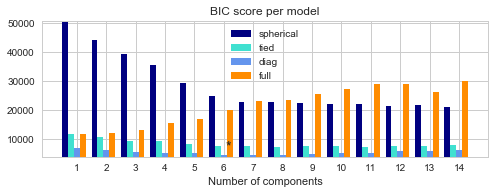

In [49]:
import itertools 

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

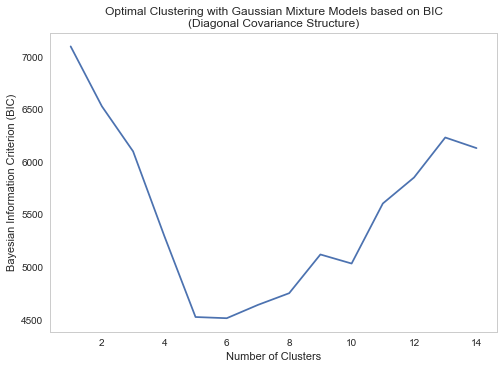

In [91]:
pretty_cov_names = {'spherical':'Spherical', 'tied':'Tied',
                    'diag':'Diagonal', 'full':'Full'}
plt.plot(bic_scores['num_components'], bic_scores[best_gmm.covariance_type])
plt.xlabel('Number of Clusters')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.grid(False)
plt.title('Optimal Clustering with Gaussian Mixture Models based on BIC\n(' \
           + pretty_cov_names[best_gmm.covariance_type] + ' Covariance Structure)')
plt.show()

In [98]:
labels_array = np.array(labels)  # dtype='<U13'
np.unique(np.array(labels))  # Addiction, Anxiety, Autism, Bipolar, Conversation, Depression, Happy, Schizophrenia

array(['addiction', 'anxiety', 'autism', 'bipolar', 'conversation',
       'depression', 'happy', 'schizophrenia'],
      dtype='<U13')

In [120]:
# NOTE: Running this code on 33,996 samples took ~20 minutes on my local machine.
from sklearn.manifold import TSNE
embeddings_tsne = TSNE(n_components=2, verbose=1)
embeddings_tsne_scores = embeddings_tsne.fit_transform(psycho_embeddings_pca_scores)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.005s...
[t-SNE] Computed neighbors for 700 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 1.190524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.656338
[t-SNE] Error after 1000 iterations: 0.588690


In [128]:
np.unique(psycho_labels)

array(['addiction', 'anxiety', 'autism', 'bipolar', 'depression', 'happy',
       'schizophrenia'],
      dtype='<U13')

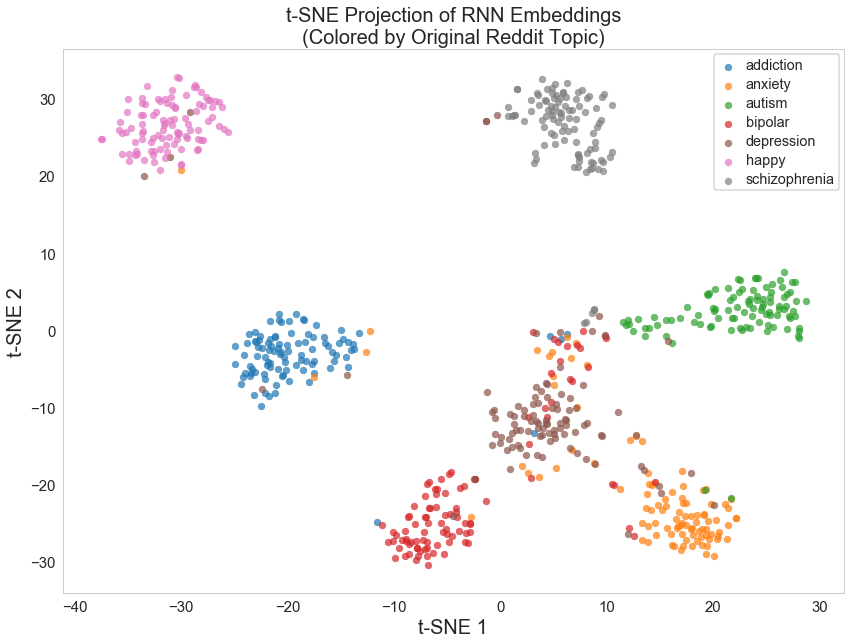

In [130]:
fig, ax = plt.subplots(figsize=(14,10))
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)

plt.title('t-SNE Projection of RNN Embeddings\n' + \
           '(Colored by Original Reddit Topic)', fontsize=20)
for y in np.unique(psycho_labels):
    ax.scatter(embeddings_tsne_scores[psycho_labels == y, 0],
               embeddings_tsne_scores[psycho_labels == y, 1], 
               label = y,
               color = color_map[label_cluster_dict[y]],
               alpha=0.7,
               cmap='tab10')
ax.grid(False)
legend = plt.legend(loc='lower right')
legend = plt.legend(frameon = 1)
for txt in legend.get_texts():
    txt.set_size('large')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# plt.setp(frame.get_texts(), fontsize='12')
plt.show()

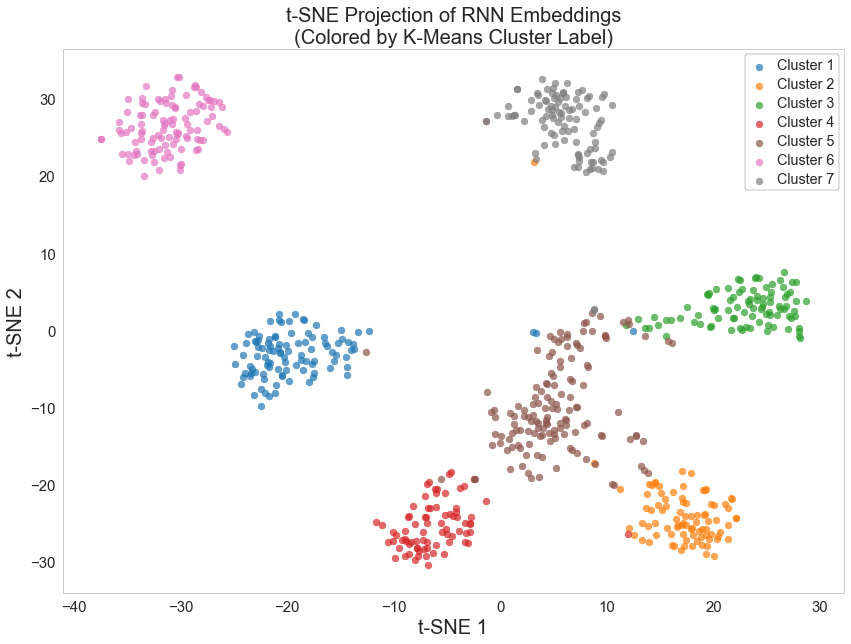

In [145]:
fig, ax = plt.subplots(figsize=(14,10))
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)

plt.title('t-SNE Projection of RNN Embeddings\n' + \
           '(Colored by K-Means Cluster Label)', fontsize=20)
for y in np.unique(mapped_cluster_labels):
    color_indx = y if y < 4 else y + 1  # Have to account for the stupid conversation label
    ax.scatter(embeddings_tsne_scores[mapped_cluster_labels == y, 0],
               embeddings_tsne_scores[mapped_cluster_labels == y, 1], 
               label = 'Cluster ' + str(y + 1),
               color = color_map[color_indx],
               alpha=0.7,
               cmap='tab10')
ax.grid(False)
legend = plt.legend(loc='lower right')
legend = plt.legend(frameon = 1)
for txt in legend.get_texts():
    txt.set_size('large')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# plt.setp(frame.get_texts(), fontsize='12')
plt.show()

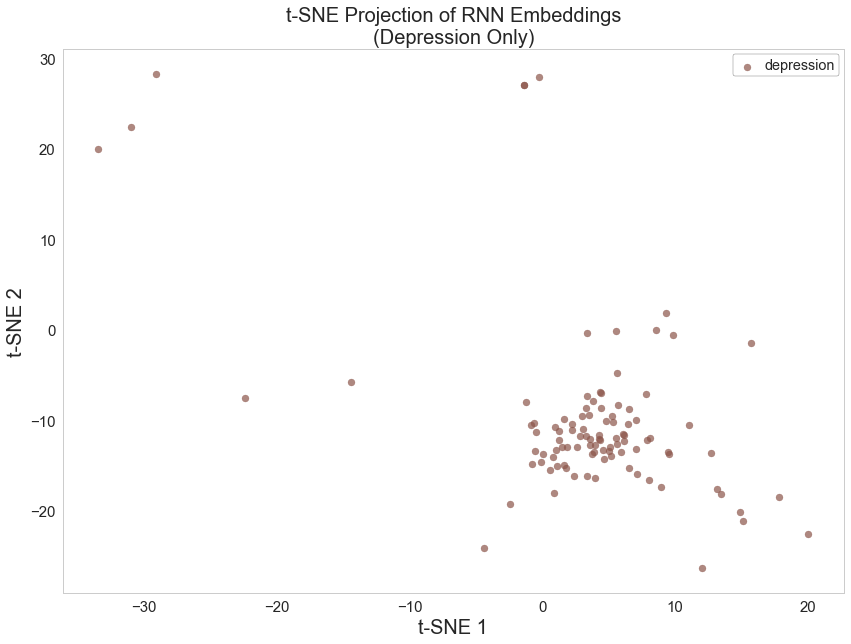

In [131]:
fig, ax = plt.subplots(figsize=(14,10))
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)

plt.title('t-SNE Projection of RNN Embeddings\n' + \
           '(Depression Only)', fontsize=20)
for y in ['depression']:
    ax.scatter(embeddings_tsne_scores[psycho_labels == y, 0],
               embeddings_tsne_scores[psycho_labels == y, 1], 
               label = y,
               color = color_map[label_cluster_dict[y]],
               alpha=0.7,
               cmap='tab10')
ax.grid(False)
legend = plt.legend(loc='lower right')
legend = plt.legend(frameon = 1)
for txt in legend.get_texts():
    txt.set_size('large')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# plt.setp(frame.get_texts(), fontsize='12')
plt.show()

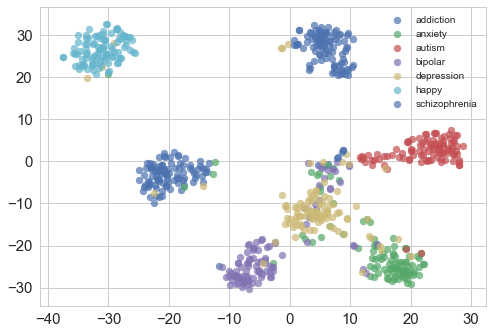

In [123]:
fig, ax = plt.subplots()
# for y in ['addiction', 'anxiety', 'depression']:
for y in np.unique(psycho_labels):
    ax.scatter(embeddings_tsne_scores[psycho_labels == y, 0],
               embeddings_tsne_scores[psycho_labels == y, 1], 
               label = y,
               alpha=0.7,
               cmap=plt.cm.jet)
ax.legend()
plt.show()

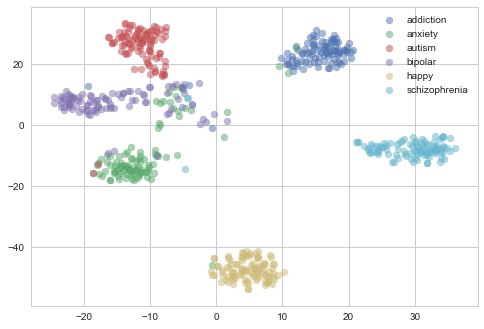

In [59]:
fig, ax = plt.subplots()
# for y in ['addiction', 'anxiety', 'depression']:
for y in np.unique(psycho_labels):
    if y == 'depression' or y == 'conversation':
        continue
    ax.scatter(embeddings_tsne_scores[psycho_labels == y, 0],
               embeddings_tsne_scores[psycho_labels == y, 1], 
               label = y,
               alpha=0.5)
ax.legend()
plt.show()

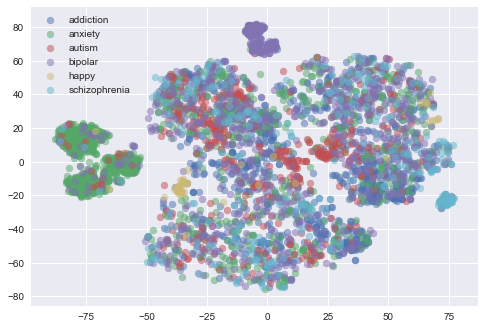

In [111]:
fig, ax = plt.subplots()
# for y in ['addiction', 'anxiety', 'depression']:
for y in np.unique(labels):
    if y == 'depression' or y == 'conversation':
        continue
    ax.scatter(embeddings_tsne_scores[labels_array == y, 0],
               embeddings_tsne_scores[labels_array == y, 1],
               label = y,
               alpha=0.5)
ax.legend()
plt.show()

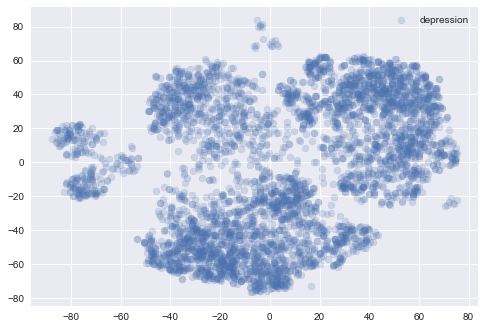

In [110]:
plt.scatter(embeddings_tsne_scores[labels_array == 'depression', 0],
               embeddings_tsne_scores[labels_array == 'depression', 1], 
               label = 'depression',
               alpha=0.2)
plt.legend()
plt.show()

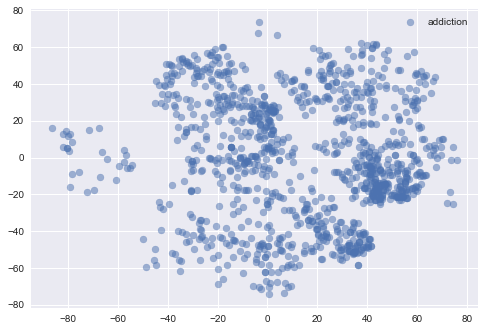

In [105]:
plt.scatter(embeddings_tsne_scores[labels_array == 'addiction', 0],
               embeddings_tsne_scores[labels_array == 'addiction', 1], 
               label = 'addiction',
               alpha=0.5)
plt.legend()
plt.show()

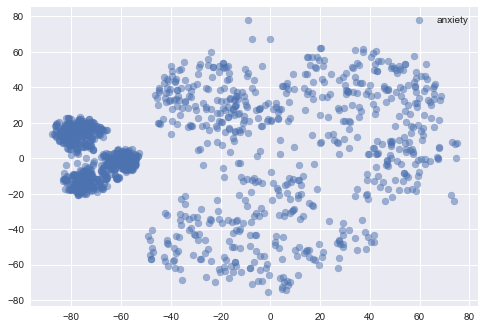

In [106]:
plt.scatter(embeddings_tsne_scores[labels_array == 'anxiety', 0],
               embeddings_tsne_scores[labels_array == 'anxiety', 1], 
               label = 'anxiety',
               alpha=0.5)
plt.legend()
plt.show()

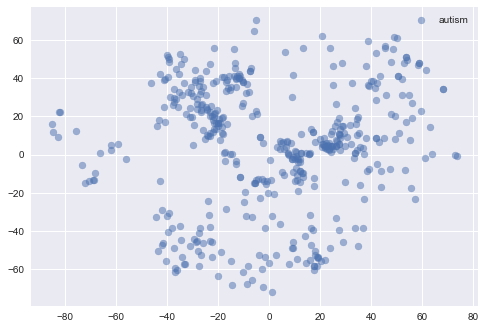

In [107]:
plt.scatter(embeddings_tsne_scores[labels_array == 'autism', 0],
               embeddings_tsne_scores[labels_array == 'autism', 1], 
               label = 'autism',
               alpha=0.5)
plt.legend()
plt.show()

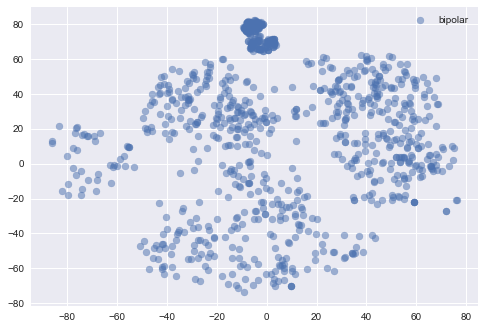

In [108]:
plt.scatter(embeddings_tsne_scores[labels_array == 'bipolar', 0],
               embeddings_tsne_scores[labels_array == 'bipolar', 1], 
               label = 'bipolar',
               alpha=0.5)
plt.legend()
plt.show()

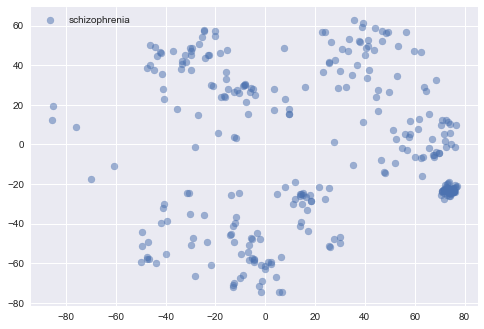

In [109]:
plt.scatter(embeddings_tsne_scores[labels_array == 'schizophrenia', 0],
               embeddings_tsne_scores[labels_array == 'schizophrenia', 1], 
               label = 'schizophrenia',
               alpha=0.5)
plt.legend()
plt.show()